In [2]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

# plt.style.use('ggplot')
jax.default_backend()   

plt.rcParams.update({
    "font.weight": "bold",
    "axes.labelweight": "bold",  
    "axes.titleweight": "bold",   
    "axes.grid": True,
    "grid.alpha": 0.5
})

## Gaussian Spectrum

In [3]:
K = 200
N = 32
uniform_points, bins = generate_uniform_radial_sampling_points(N)
H, samples =  generate_gaussian_rpsd_data(K,N,2)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/rpsd_test_data.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [4]:
factorization = factorize_RPSD(samples)

/tmp/ipykernel_1542689/1555312022.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


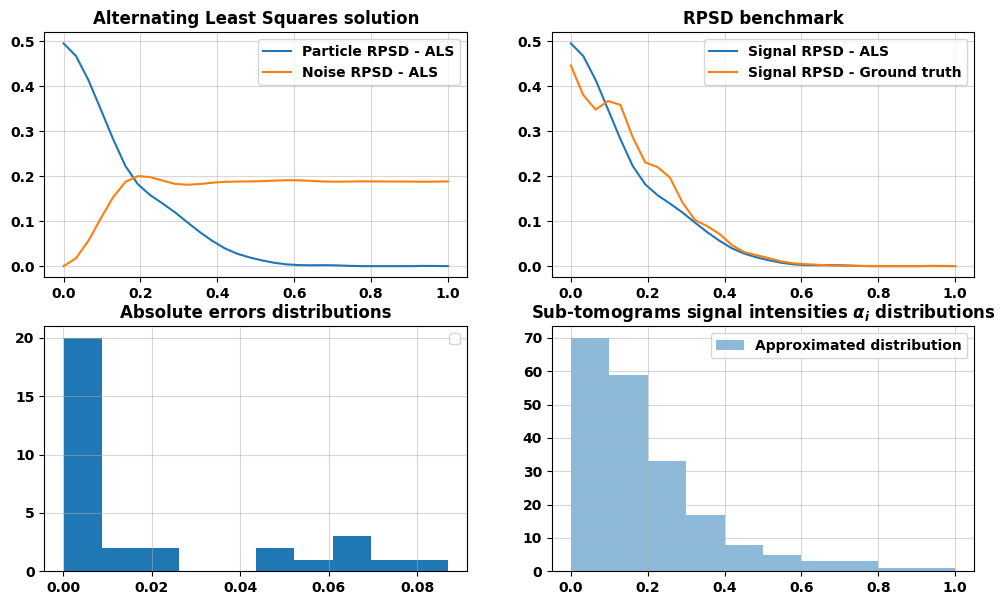

In [5]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

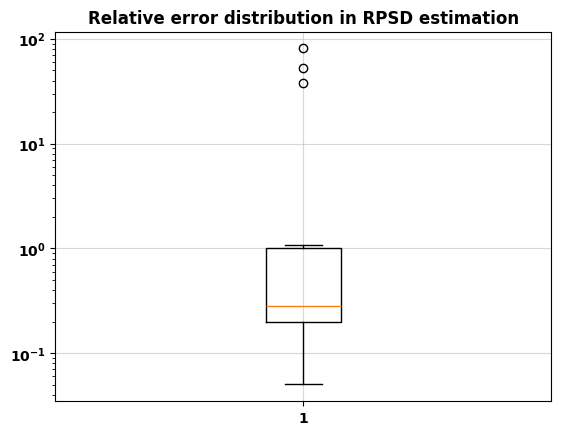

In [11]:
plt.title("Relative error distribution in RPSD estimation")
plt.yscale('log')
plt.boxplot(np.abs(true_rpsd - particle_psd)/np.abs(true_rpsd));

In [112]:
import scipy
from scipy.special import legendre
import scipy.integrate as integrate

def cpu_integral_equation_solver(Gx,N,K=150):
  def Hn(x):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u),0,1)[0]
  
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5

  vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])
  def psi_even(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)
  
  def psi_odd(i,j):
     return 0.5 * np.sum(w * (-vv[j,:]) * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  psi = psi_even if N % 2 == 0 else psi_odd
  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])

  eigenvalues, eigenvectors = np.linalg.eigh(U)
  return eigenvalues,eigenvectors

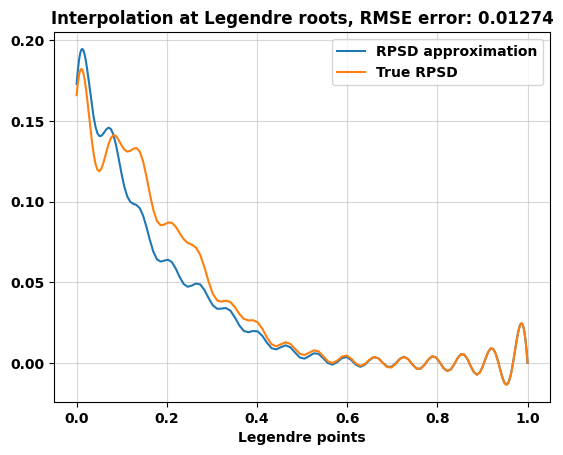

In [13]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre points")
plt.legend();

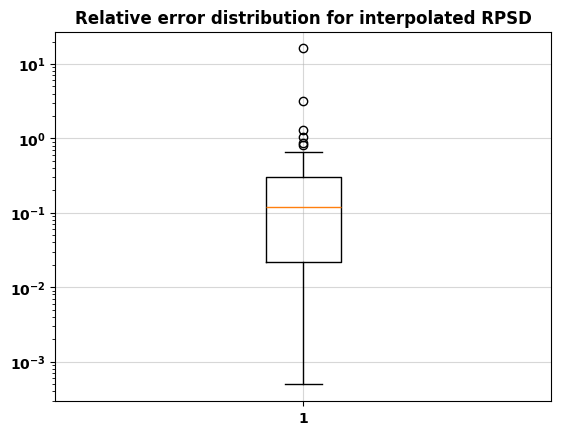

In [22]:
plt.title("Relative error distribution for interpolated RPSD")
plt.yscale('log')
plt.boxplot(np.abs(Gx_true - Gx)/ np.abs(Gx));

The low frequencies contribute large relative errors, it's not clear yet how much can reduce the error on his frequency cut-off.

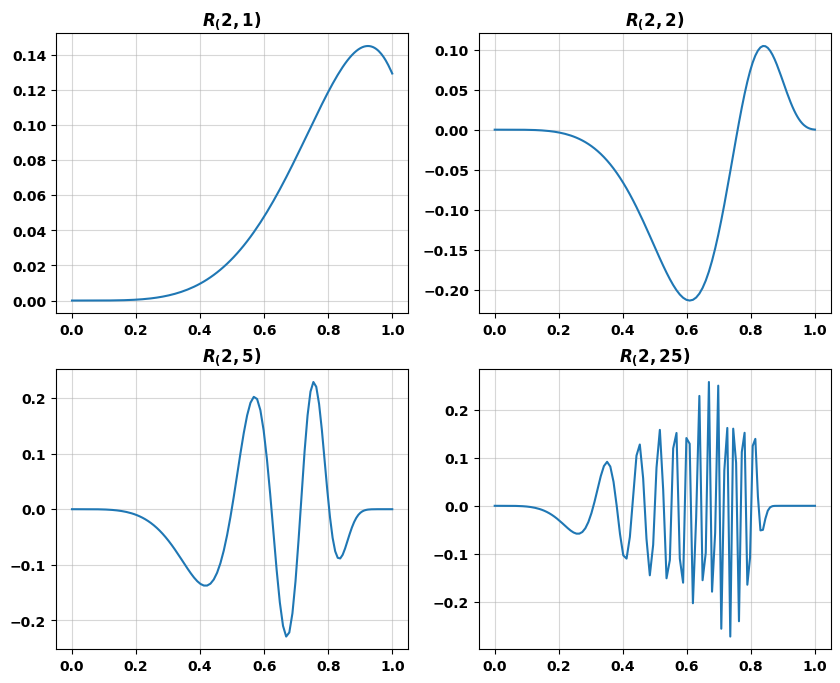

In [98]:
order = 2
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = eigenvalues[::-1]
eigenfunctions = eigenfunctions[:,::-1]

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,24])
ax[1,1].set_title(f"$R_{order,25}$");

One can observe that $R_{N,m}$ for a fixed $N$ is in a sense a shifted and "squeezed" copy of the same function.

In [99]:
ids = np.where(eigenvalues > np.spacing(1))[0]
eigvals = eigenvalues[ids]
p = (1 -  ids.shape[0]/150)*100
print(f"{p:.1f}% of eigenvalues are irrelevant (smaller than machine precision)")

37.3% of eigenvalues are irrelevant (smaller than machine precision)


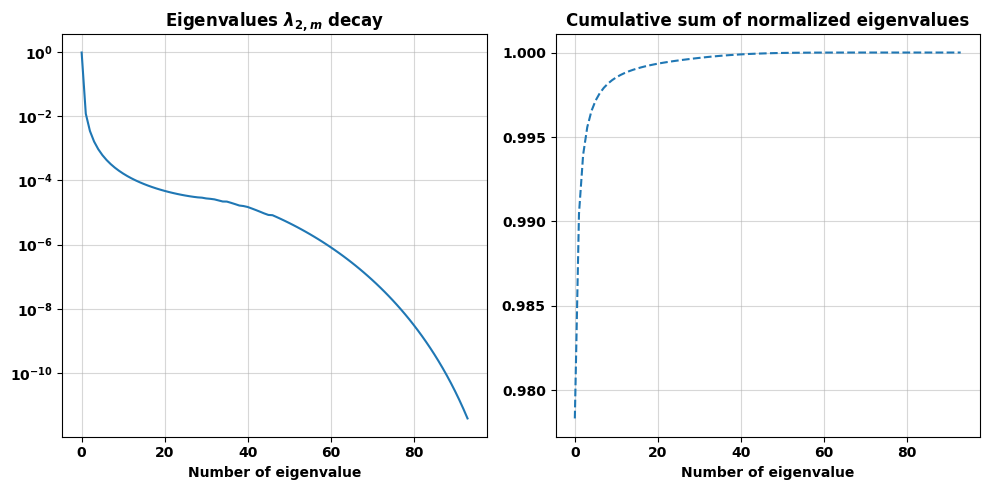

In [106]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title(r"Eigenvalues $\lambda_{2,m}$ decay")
ax[0].plot(eigvals/np.sum(eigvals))
ax[0].set_xlabel("Number of eigenvalue")
ax[0].set_yscale('log');

ax[1].set_title("Cumulative sum of normalized eigenvalues")
eigvals_sum = np.cumsum(eigvals/np.sum(eigvals))
ax[1].plot(eigvals_sum,'--')
ax[1].set_xlabel("Number of eigenvalue")
#ax[1].set_yscale('log')

plt.tight_layout();

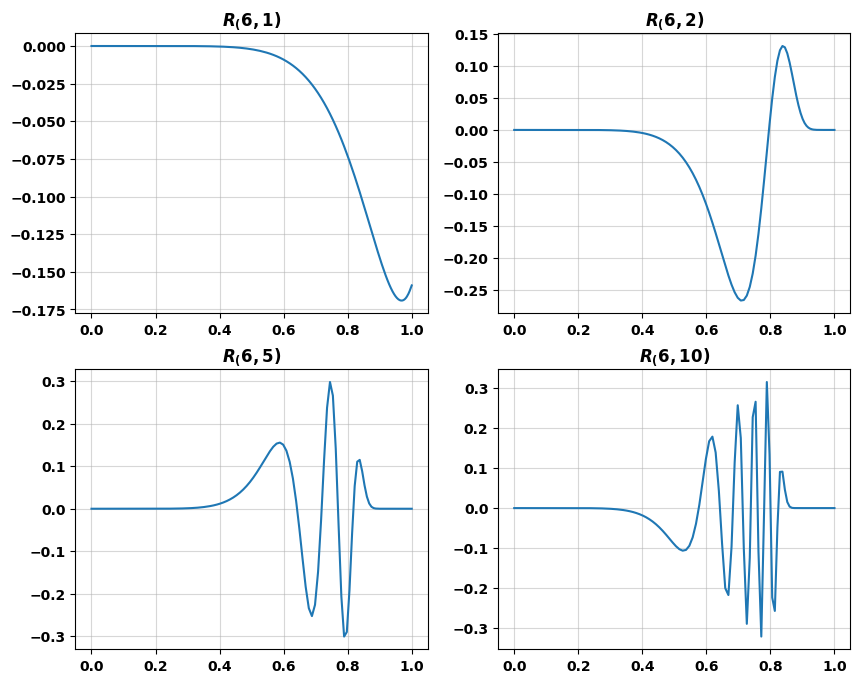

In [97]:
order = 6
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = eigenvalues[::-1]
eigenfunctions = eigenfunctions[:,::-1]

fig, ax = plt.subplots(2,2, figsize=(10,8))


ax[0,0].plot(X_scaled,eigenfunctions[:,0])
ax[0,0].set_title(f"$R_{order,1}$")

ax[0,1].plot(X_scaled,eigenfunctions[:,1])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,4])
ax[1,0].set_title(f"$R_{order,5}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,9])
ax[1,1].set_title(f"$R_{order,10}$");

In [141]:
orders = np.arange(10)

eigvals = []
eigfuncs = []
for order in np.arange(10):
    eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
    eigvals.append(eigenvalues)
    eigfuncs.append(eigenfunctions)

In [142]:
eigfuncs = np.array(eigfuncs).reshape(-1,150)
eigvals = np.array(eigvals).reshape(-1)

idx = np.argsort(eigvals)

eigfuncs = eigfuncs[idx,:]
eigvals = eigvals[idx]

idx = np.where(eigvals > np.spacing(1))[0]
eigvals = eigvals[idx][::-1]
eigfuncs = eigfuncs[idx,:][::-1,:]

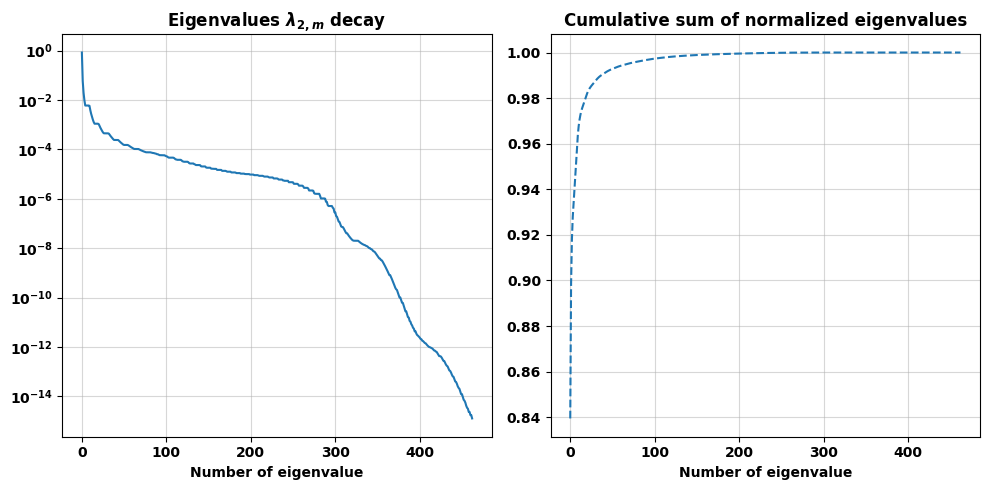

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title(r"Eigenvalues $\lambda_{2,m}$ decay")
ax[0].plot(eigvals/np.sum(eigvals))
ax[0].set_xlabel("Number of eigenvalue")
ax[0].set_yscale('log');

ax[1].set_title("Cumulative sum of normalized eigenvalues")
eigvals_sum = np.cumsum(eigvals/np.sum(eigvals))
ax[1].plot(eigvals_sum,'--')
ax[1].set_xlabel("Number of eigenvalue")
#ax[1].set_yscale('log')

plt.tight_layout();

In [194]:
print(f"Most of the mass at th first {(eigvals_sum > 0.9).argmax() + 1} eigenvalues")

Most of the mass at th first 3 eigenvalues


In [186]:
inner_prods = (eigfuncs.T  @ eigfuncs) / eigfuncs.shape[1]
inner_prods = inner_prods[(1 - np.eye(150)).astype(bool)]

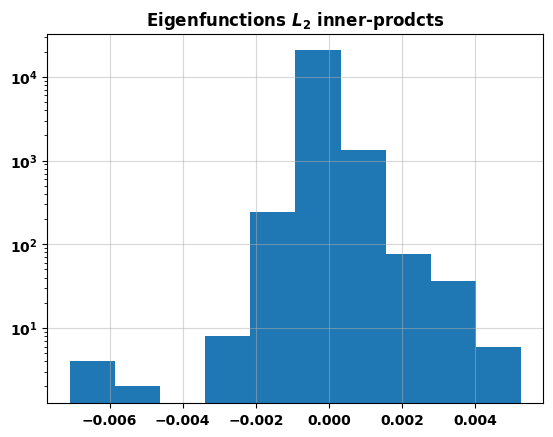

In [192]:
plt.title("Eigenfunctions $L_2$ inner-prodcts")
plt.hist(inner_prods)
plt.yscale('log');

In our experiment the eigenvalues decay so fast that all of the important mass is at the first eigenvalue. Hence we can resort to reducing the eigenfunctions by reducing to $R_N$ and dropping all of the $R_N,m$ functions.

Note the solutions are of the form:

$$ \psi_{N,m,n}(r,\theta,\phi) = R_{N,m}(r) Y_n^m(\theta,\phi)$$

This function is 4-dimensional hence instead we will visualize slices of it. As the Spherical Harmonics are defined:

$ Y_n^{m} ( \theta, \phi ) =  \sqrt{\frac{2n+1}{4 \pi} \frac{(n-m)!}{(n+m)!}} e^{im\theta} P_n^m(\cos(\phi)) $

We cana fix $ \phi=0$ and plot the eigenfunction up to a constant.

In [59]:
order = 2
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = eigenvalues[::-1]
eigenfunctions = eigenfunctions[:,::-1]

/tmp/ipykernel_1542689/3112651286.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='seismic')


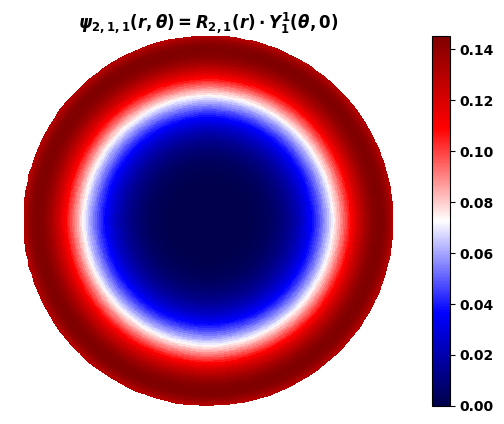

In [111]:
N = 150 
R = eigenfunctions[:,0].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)

R_2d = np.tile(R[:, np.newaxis], (1, N))
plt.pcolormesh(X, Y, R_2d,cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{2,1,1}(r, \theta) = R_{2,1}(r) \cdot Y_1^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

## Power Law Spectra

In [175]:
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))

In [267]:
K = 200
N = 32
M = 2*N - 1 
max_d = int(np.floor(N/3))

uniform_points, bins = generate_uniform_radial_sampling_points(N)

T = -np.log(1e-15)/30
grid = np.arange(-(N-1),N)
i,j,k = np.meshgrid(grid,grid,grid)
r = np.sqrt(i**2 + j**2 + k**2) 
H = 1/(( 1+ r**2) ** 0.5)
C = M**3 / H.sum()
normalized_H = jnp.fft.ifftshift(jnp.sqrt(H * C))

samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K))   

std = 1
for i in range(K):
    gaussian_noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=std,size=(M,M,M))
    sample = jnp.fft.ifftn(jnp.fft.fftn(gaussian_noise) * normalized_H)
    sample = alphas[i]*sample + additive_noise
    samples[i] = sample[:N,:N,:N].real

In [268]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psds = vect_spectrum_estimation(samples,max_d)

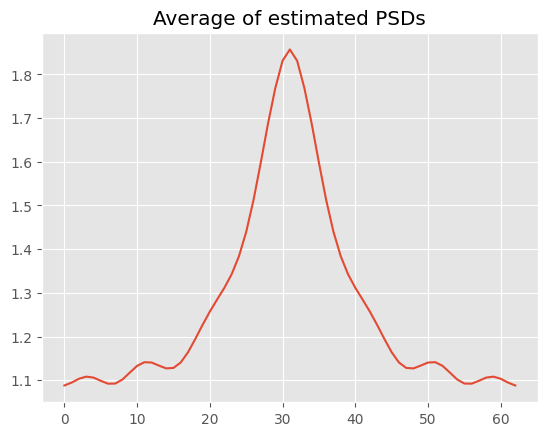

In [269]:
plt.title("Average of estimated PSDs");
plt.plot(np.mean(psds,axis=0)[N,N,:]);

In [270]:
rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_807015/3199449343.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


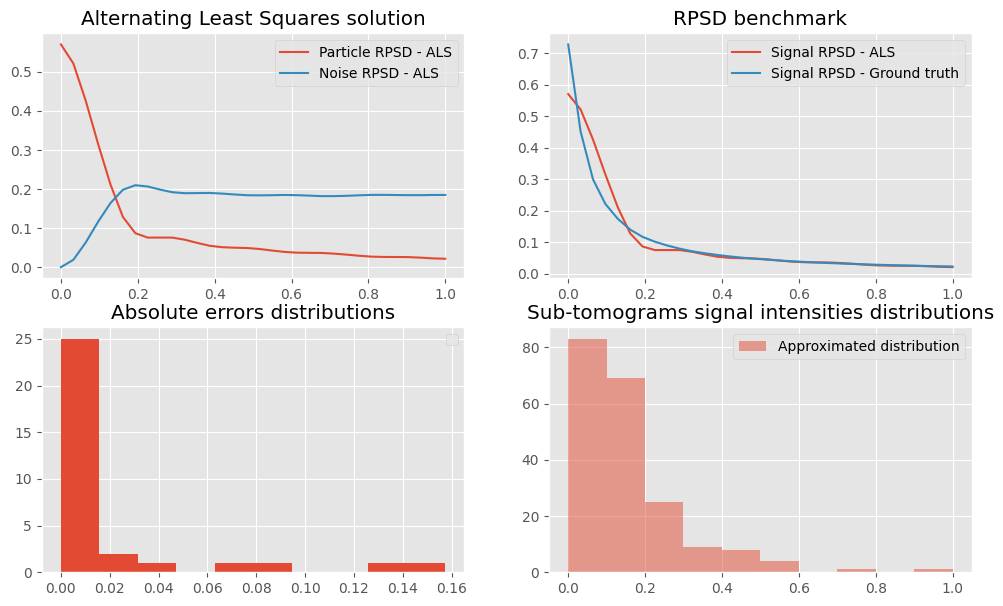

In [271]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

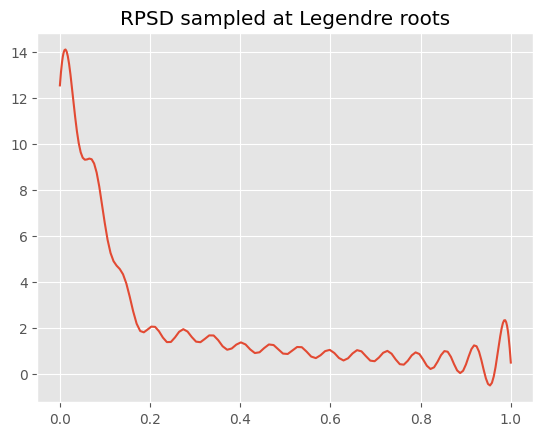

In [272]:
import scipy
from scipy.special import legendre
import scipy.integrate as integrate

def cpu_integral_equation_solver(Gx,N,K=150):
  def Hn(x):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u),0,1)[0]
  
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5

  vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])
  def psi(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])

  eigenvalues, eigenvectors = scipy.linalg.eig(U)
  return eigenvalues,eigenvectors

particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
plt.title("RPSD sampled at Legendre roots")
plt.plot(X_scaled, Gx);

In [277]:
order = 1
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/tmp/ipykernel_807015/147154175.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R_2d,cmap='seismic')


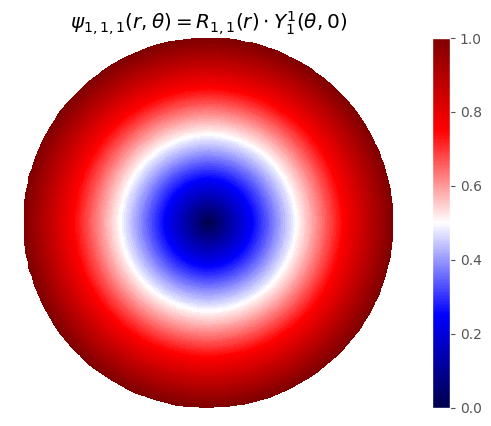

In [278]:
N = 150 
R = eigenfunctions[:,indices[0]].real 

theta = np.linspace(0, 2*np.pi, N)

theta_g, r_g = np.meshgrid(theta, X_scaled )

X = r_g * np.cos(theta_g)
Y = r_g * np.sin(theta_g)


R_norm = 2*(R - R.min())/(R.max() - R.min()) - 1
R_colors = 0.5*(R_norm + 1)
R_2d = np.tile(R_colors[:, np.newaxis], (1, N))

plt.pcolormesh(X, Y, R_2d,cmap='seismic')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axis('equal')
plt.title(r'$\psi _{1,1,1}(r, \theta) = R_{1,1}(r) \cdot Y_1^1(\theta, 0)$')
plt.colorbar()
plt.axis('off');

Notes to self:
- The interpolated RPSD seems to be quite similar in result. Needs to check it on the actual value by radial averaing over the X_scaled as magnitudes. 
- The results of Fredholm solver seems a bit too much redundant? I'm not sure if it's expected to have so much little data in high orders eigenvalues for a fixed N. 
- When tested on a slower PSD the resulting RPSD seemed a bit off, why? 
- The Fredholm equation is integreated up to a or c (bandwith of particle's function and diameter of particle). What if it's bigger than 1? How can one interpolate the RPSD well? 